# Load packages

In [0]:
# !mv RetinaNet.py SorghumHeadDetection/RetinaNet/RetinaNet.py

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
! git clone https://github.com/nik-hil/SorghumHeadDetection.git
from SorghumHeadDetection.RetinaNet import *

In [11]:
BoundingBox

SorghumHeadDetection.RetinaNet.BoundingBox.BoundingBox

In [0]:
import os
import PIL
import math
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor, tensor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects

from SorghumHeadDetection.RetinaNet.object_detection_helper import process_output, nms, rescale_boxes, show_results, GeneralEnsemble

import fastai
from fastai.core import is_tuple
from fastai.torch_core import to_np
from fastai.basic_train import _loss_func2activ, validate, progress_bar, loss_batch
from fastai.vision.data import pil2tensor
from fastai.vision import Path, open_image, ImageBBox, ObjectItemList, get_transforms, bb_pad_collate, conv_layer, Learner, create_body, models, conv2d, ifnone, DatasetType, range_of, progress_bar, ShowGraph, get_preds, Image

In [0]:
from SorghumHeadDetection.RetinaNet.object_detection_helper import create_anchors, show_results_side_by_side, get_annotations_from_path
from SorghumHeadDetection.RetinaNet.RetinaNetFocalLoss import FocalLoss
from SorghumHeadDetection.RetinaNet.RetinaNet import RetinaNet
from SorghumHeadDetection.RetinaNet.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define paths

In [0]:
DATA = Path("/content/drive/My Drive/data/sorghum_train_public")

IMAGES = DATA/'train_labelled_images'
TEST_IMAGES = DATA/'test_images'
ANNOTATIONS = DATA/'train_labelled_annotations'


In [0]:
images, lbl_bbox = get_annotations_from_path(ANNOTATIONS, IMAGES)
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[IMAGES/o.name]

In [0]:

def get_data(bs, size):
    src = ObjectItemList.from_folder(IMAGES)
    src = src.split_by_rand_pct(0.1)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=IMAGES, bs=16, collate_fn=bb_pad_collate)

In [0]:
batch_size = 64
image_size = 256

data = get_data(batch_size, image_size)
# data.show_batch(3)

In [0]:
anchors = create_anchors(sizes=[(32,32), (16,16),(8,8),(4,4),(2,2)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 1])

n_classes = data.train_ds.c

crit = FocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=9, sizes=[32,16,8,4,2], chs=32, final_bias=-4., n_conv=2)



In [0]:
voc = PascalVOCMetric(anchors, image_size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics], metrics=[voc])

# Learner

In [0]:

learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,2.870946,2.576774,0.008917,0.572982,2.003792,0.008917,00:12
1,2.608862,2.555599,0.023242,0.549623,2.005976,0.023242,00:13
2,2.256659,1.726651,0.031486,0.511436,1.215215,0.031486,00:13
3,1.926691,1.482334,0.086993,0.485352,0.996982,0.086993,00:13
4,1.691771,1.217217,0.061854,0.458808,0.758409,0.061854,00:13
5,1.520241,1.160791,0.059573,0.452815,0.707975,0.059573,00:13
6,1.392241,1.105141,0.085361,0.422641,0.682499,0.085361,00:13
7,1.291256,1.102508,0.083328,0.416604,0.685904,0.083328,00:13
8,1.205920,1.032304,0.093547,0.382937,0.649367,0.093547,00:13
9,1.132316,0.991722,0.112063,0.368945,0.622777,0.112063,00:13


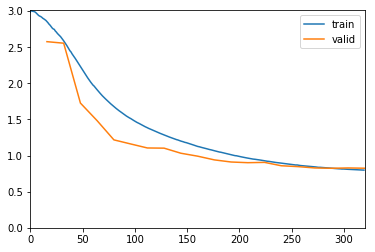

In [26]:
learn.fit_one_cycle(50, 2e-4)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,0.774034,0.824836,0.152150,0.327972,0.496864,0.152150,00:13
1,0.769026,0.827457,0.153301,0.327013,0.500444,0.153301,00:13
2,0.771186,0.818629,0.157286,0.325014,0.493615,0.157286,00:13
3,0.769327,0.813537,0.159026,0.324577,0.488960,0.159026,00:13
4,0.767634,0.811902,0.165169,0.326102,0.485800,0.165169,00:13
5,0.762505,0.797726,0.175610,0.324613,0.473113,0.175610,00:13
6,0.757885,0.794934,0.159195,0.314260,0.480674,0.159195,00:13
7,0.755738,0.792914,0.172941,0.322828,0.470085,0.172941,00:13
8,0.749013,0.780310,0.176023,0.322589,0.457721,0.176023,00:13
9,0.740937,0.769451,0.185115,0.325227,0.444224,0.185115,00:13


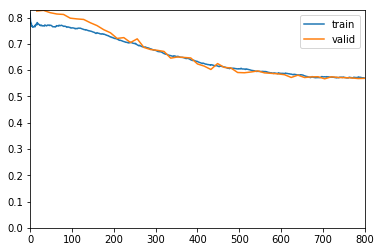

In [31]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

In [0]:
learn.save('stage2-50')

In [0]:
learn.export("stage2-50-export")

In [0]:
from SorghumHeadDetection.RetinaNet.inference import get_bounding_box_predictions_for_dataset, setupNewCrop, get_bounding_box_predictions


In [34]:
all_preds = list(get_bounding_box_predictions_for_dataset(learn, anchors))

print(len(all_preds))

30


In [0]:
#Let's test this out on a single slice and plot the resulting bboxes on to our image
dl = learn.dl(DatasetType.Valid)

old_open_image = fastai.vision.data.open_image

i = 4
j = 1
original_images = list(dl.x)
setupNewCrop(i, j)

all_imgs, all_boxes, all_scores = get_bounding_box_predictions(learn, dl, anchors, original_images, i,j)

fastai.vision.data.open_image = old_open_image

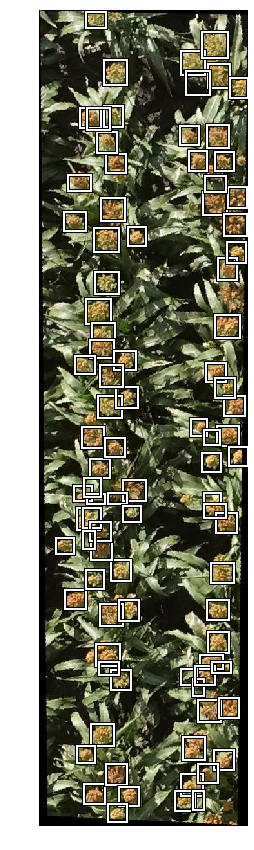

In [30]:
img_idx = 0

def show_img_bbox(img_idx):
    newBoundingBoxes = []
    for bbox in all_preds[img_idx]:
        newBoundingBoxes.append([bbox[0], bbox[1], bbox[2], bbox[3]])

    classId = [0 for _ in range(len(newBoundingBoxes))]

    img = all_imgs[img_idx]

    bbox = ImageBBox.create(*img.size, newBoundingBoxes, classId, classes=[''])
    img.show(figsize=(15,15), y=bbox)
    
show_img_bbox(img_idx)

In [0]:
# %matplotlib inline
# import ipywidgets as widgets 
# from ipywidgets import Output
# from IPython.display import display, clear_output
# button = widgets.Button(description="Click Me! " + str(img_idx))
# display(button)
# out = Output()
# display(out)

# def fun(a):
#     print(a)

# def on_button_clicked(b):
#     global img_idx 
#     img_idx += 1
#     with out:
#         clear_output()
#         show_img_bbox(img_idx)
#         fun(img_idx)

    
# button.on_click(on_button_clicked)

In [0]:
# Create test data loader and call "get_bounding_box_predictions"

In [0]:
def no_tfms(self, x, *args, **kwargs): return x
EmptyLabel.apply_tfms = no_tfms


def get_test_data(bs, size):
    src = ObjectItemList.from_folder(IMAGES)
    src = src.split_by_rand_pct(0.1)
    src = src.label_from_func(get_y_func)
    src = src.add_test(ItemList.from_folder(TEST_IMAGES),label=None)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=IMAGES, bs=16, collate_fn=bb_pad_collate)


In [0]:
learn.data = get_test_data(batch_size, image_size)

In [0]:
all_preds = list(get_bounding_box_predictions_for_dataset(learn, anchors, ds_type=DatasetType.Test))

print(len(all_preds))